In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn import decomposition
import functions as fns

In [2]:
#Se importa el csv. Hubo que cambiar el encoder.
granos = pd.read_csv('estimaciones.csv', delimiter=',', encoding='latin-1')

In [3]:
#Puede notarse que producción tenía un espacio al final, por lo cual se renombra para quitar al mismo
granos.rename (columns={'produccion ' : 'produccion'}, inplace=True)

In [4]:
#   Se crean dos tablas, una para cultivos y otra para provincias que relacionan el id con el nombre. Esto es conveniente
#   por ejemplo, en el caso de los cultivos, el número de id también coincide con la posición en el índice.

cultivos = granos.groupby(['id_cultivo'])['cultivo'].max()
cultivos = pd.DataFrame(cultivos)
#print (cultivos)
provincias = granos.groupby(['id_provincia'])['provincia'].max()
provincias = pd.DataFrame(provincias)
#print (provincias)

<font size="5"><b>Modelo 1: Knn classifier 

El primer modelo que se entrenará con este dataset es uno de clasificación. El objetivo del mismo será que uno pueda ingresar muestras nuevas de la producción por cultivo para un año de una provincia desconocida y que el clasificador defina a que provincia pertenece esa muestra.

In [5]:
#   Se realiza un proceso similar al que se realizó durante el EDA. Se genera un diccionario que tendrá una entrada por cada 
#   cultivo y cuyas columnas serán para cada campaña, la producción de ese cultivo por provincia. Esto vuelve a generar una 
#   tabla con Nans debido a que no todos los cultivos se producen en todas las pronvincias y hay cultivos que no tienen datos
#   para todos los años que abarca el dataset.

k = {}
for i in range(1,34):
    aux= granos[(granos.id_cultivo == i)]
    aux=aux.groupby(['campaña',"provincia"], as_index=True)['produccion'].sum()
    aux=pd.DataFrame(aux)
    k[i] = aux.iloc[:,0]
    
#   Luego de generado el diccionario, se lo transforma en un data set cuyas column labels son los id de cultivos. y se vuelve a
#   iterar con ayuda del DataFrame "cultivos", para renombrar todas las columnas, reemplazando el id de cultivo con el nombre
#   del cultivo con el que se corresponde. Se realiza un df.head() para  visualizar la forma final del DataFrame.

mod1 = pd.DataFrame.from_dict(k)
for i in range (1,34):
    if i in mod1.columns:
        l = str (cultivos.at[i,"cultivo"])
        mod1.rename(columns = { i : l}, inplace=True)
mod1.head()

Ajo   Algodón   Alpiste   Arroz     Avena  Banana  \
campaña   provincia                                                             
1969/1970 BUENOS AIRES  23458.0       NaN  104000.0     NaN  404700.0     NaN   
          CATAMARCA        90.0     101.0       NaN     NaN     120.0     NaN   
          CHACO           560.0  263000.0       NaN  3200.0       0.0     NaN   
          CHUBUT          630.0       NaN       NaN     NaN       0.0     NaN   
          CORDOBA        1900.0    1220.0     900.0     NaN    1500.0     NaN   

                        Caña de azúcar  Cártamo  Cebada cervecera  \
campaña   provincia                                                 
1969/1970 BUENOS AIRES             NaN      NaN          412800.0   
          CATAMARCA                NaN      NaN               NaN   
          CHACO               117600.0    105.0               NaN   
          CHUBUT                   NaN      NaN               NaN   
          CORDOBA                  NaN      NaN           40500.0   

                        Cebada forrajera  ...  Poroto seco  Soja total  \
campaña   provincia                       ...                            
1969/1970 BUENOS AIRES           60500.0  ...        180.0      1600.0   
          CATAMARCA                400.0  ...        187.0         NaN   
          CHACO                      0.0  ...          NaN       110.0   
          CHUBUT                     0.0  ...         70.0         NaN   
          CORDOBA                 1200.0  ...       1000.0         NaN   

                            Sorgo  Té  Trigo total  Trigo candeal  Tung  \
campaña   provincia                                                       
1969/1970 BUENOS AIRES   880000.0 NaN    4882600.0            NaN   NaN   
          CATAMARCA         100.0 NaN        450.0            NaN   NaN   
          CHACO          275000.0 NaN      24550.0            NaN   NaN   
          CHUBUT              NaN NaN          0.0            NaN   NaN   
          CORDOBA       1100000.0 NaN     638500.0            NaN   NaN   

                        Yerba mate       Maíz  Cebada total  
campaña   provincia                                          
1969/1970 BUENOS AIRES         NaN  3729800.0           NaN  
          CATAMARCA            NaN     1500.0           NaN  
          CHACO                NaN    38400.0           NaN  
          CHUBUT               NaN        NaN           NaN  
          CORDOBA              NaN  1320000.0           NaN  

[5 rows x 33 columns]

In [6]:
#   El atributo "provincia" que se había importado como índice, se transforma en columna

mod1.reset_index("provincia", inplace=True)

In [7]:
#  Se elimina el año en el que fue tomada la muestra, ya que es un dato que no necesitamos para lograr el objetivo de este
#  clasificador.

mod1.reset_index(drop=True, inplace=True)

A diferencia del criterio que se tomó durante la realización del EDA, en este caso se optó por reemplazar a todos los nulls 
por 0. Esto es así debido a que todas las muestras y todas las columnas los tenían (debido a las razones explicadas anteriormente), por lo que eliminarlos no era una opción y reemplazarlos por el promedio tampoco, ya que al ser cada cultivo una columna, de esta manera se hubiera llenado a distintas provincias con un mismo promedio de producción, lo cual es erróneo ya que no todos los cultivos se producen en todas las provincias ni el nivel de producción es el mismo en las distintas provincias que si los cosechan.

Si bien sabemos que esto producirá un poco de ruido en el modelo, definimos que era la mejor opción que se podía tomar.

In [8]:
#   Se procede a rellenar los NaNs con 0.

mod1.fillna(0, inplace=True)
mod1.head(10)

,provincia,Ajo,Algodón,Alpiste,Arroz,Avena,Banana,Caña de azúcar,Cártamo,Cebada cervecera,...,Poroto seco,Soja total,Sorgo,Té,Trigo total,Trigo candeal,Tung,Yerba mate,Maíz,Cebada total
0,BUENOS AIRES,23458.0,0.0,104000.0,0.0,404700.0,0.0,0.0,0.0,412800.0,...,180.0,1600.0,880000.0,0.0,4882600.0,0.0,0.0,0.0,3729800.0,0.0
1,CATAMARCA,90.0,101.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0,...,187.0,0.0,100.0,0.0,450.0,0.0,0.0,0.0,1500.0,0.0
2,CHACO,560.0,263000.0,0.0,3200.0,0.0,0.0,117600.0,105.0,0.0,...,0.0,110.0,275000.0,0.0,24550.0,0.0,0.0,0.0,38400.0,0.0
3,CHUBUT,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CORDOBA,1900.0,1220.0,900.0,0.0,1500.0,0.0,0.0,0.0,40500.0,...,1000.0,0.0,1100000.0,0.0,638500.0,0.0,0.0,0.0,1320000.0,0.0
5,CORRIENTES,0.0,11800.0,0.0,122200.0,0.0,0.0,8600.0,0.0,0.0,...,0.0,630.0,4500.0,6000.0,1150.0,0.0,3600.0,5939.0,96400.0,0.0
6,ENTRE RIOS,190.0,180.0,0.0,209400.0,3500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,335000.0,0.0,219600.0,0.0,0.0,0.0,810000.0,0.0
7,FORMOSA,30.0,66400.0,0.0,10500.0,0.0,200100.0,2400.0,0.0,0.0,...,68.0,160.0,31300.0,0.0,590.0,0.0,0.0,0.0,15000.0,0.0
8,JUJUY,256.0,1102.0,0.0,0.0,0.0,0.0,2100000.0,0.0,0.0,...,548.0,0.0,0.0,0.0,878.0,0.0,0.0,0.0,2600.0,0.0
9,LA PAMPA,0.0,0.0,0.0,0.0,11500.0,0.0,0.0,0.0,32500.0,...,0.0,0.0,233000.0,0.0,599700.0,0.0,0.0,0.0,165000.0,0.0


In [9]:
#   Separamos nuestros datos en etiquetas y variables dependientes.

X = mod1.iloc[:,1:35]                     
Y = mod1.iloc[:,0]    

In [10]:
#   Transformamos en variables numéricas a nuestras etiquetas. Se puede visualizar su valor final eliminando la última anotación
#   de esta celda.

le = preprocessing.LabelEncoder()
Y=le.fit_transform(Y)
#Y

In [11]:
#   Separamos nuestro set de datos en train y test y visualizamos el tamaño de cada set de muestras.

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=9000)
print(Xtrain.shape)
print(Xtest.shape)

(652, 33)
(280, 33)


In [12]:
#   Aplicamos un standard scaler a nuestros datos ya que KNN funciona mejor con datos escalados en este caso.

scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrainsca = scaler.transform(Xtrain)
xtestsca = scaler.transform(Xtest) 

In [13]:
#   Generamos nuestro clasificador de KNN mediante un GridSearch Cross Validation y se lo fitea a nuestros datos.

parameters = [{"n_neighbors" : [1,2,3,4,5,6,7], "weights" : ["uniform","distance"], "p" : [1,2]}]
knn = KNeighborsClassifier()
clas = GridSearchCV (knn, parameters, cv=5, verbose=True)
clas.fit(Xtrainsca, Ytrain) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\Users\Santi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.1s finished
C:\Users\Santi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [14]:
print("Los mejores parametros son %s con un valor de train accuracy de %0.4f" % (clas.best_params_, clas.best_score_))

Los mejores parametros son {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'} con un valor de train accuracy de 0.9601


In [15]:
#   Se realiza la predicción del Ytest en función de la aplicación de nuestro claisificador al Xtest escalado.

ypred = clas.predict(xtestsca)

In [16]:
#   Se visualiza la precisión de la predicción y generalización de nuestro modelo  

test_acc = accuracy_score(Ytest, ypred)
print("El accuracy es %0.4f" % (test_acc))

El accuracy es 0.9393


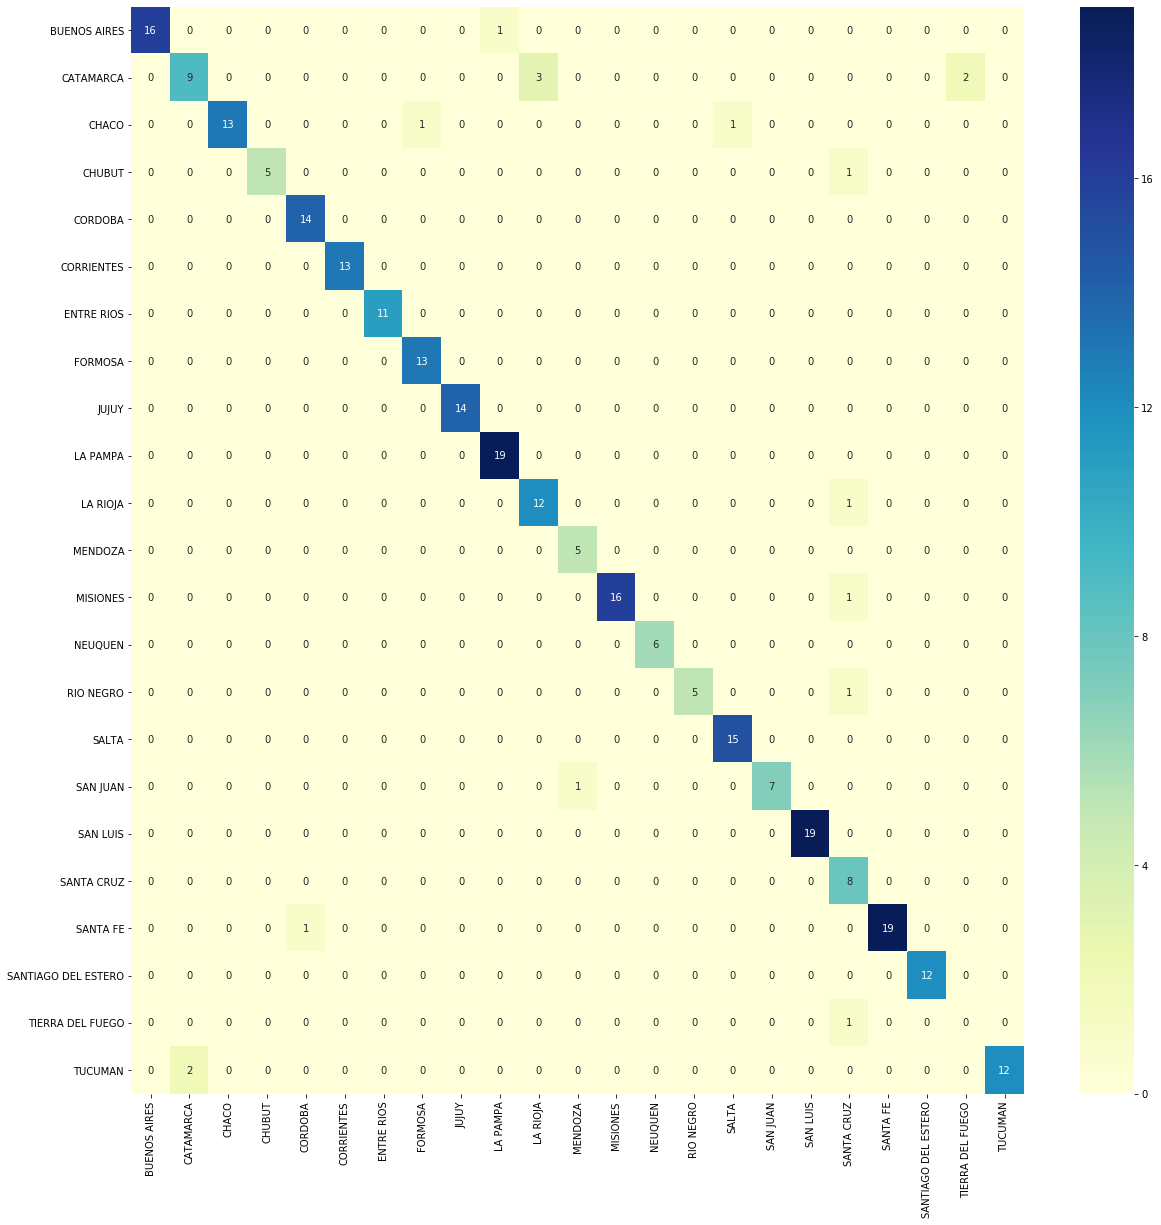

In [17]:
#   Se grafica una matriz de confusión, mostrando como desarrolló nuestro modelo la predicción. Se hace un inverse transform
#   a nuestras etiquetas para que muestren el nombre de la provincia en vez del valor numérico que se les había dado para poder
#   modelizar.

cm = confusion_matrix(Ytest, ypred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(le.inverse_transform(Y))],columns = [i for i in np.unique(le.inverse_transform(Y))])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()

<font size="6"><b>Modelo 2: K-means Clustering

Como segundo modelo a entrenar con nuestros datos se decidió realizar un clustering en función del rendimiento (Toneladas producidas por hectárea cosechada) de cada cultivo en cada provincia. La idea era obtene 5 clusters distintos que agruparan a las distintas combinaciones de estas variables.

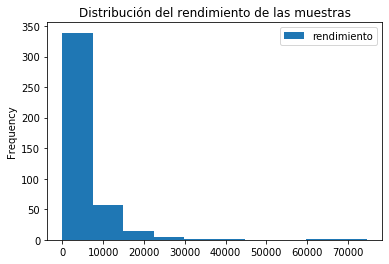

In [18]:
#   Antes de comenzar con la realización del modelo se decidió visualizar con un histograma la cantidad de samples que 
#   compartían un mismo rango de rendimiento, independientemente del cultivo y de la provincia.

mod2og = granos.groupby(['provincia','cultivo'], as_index=False)['rendimiento'].mean()
vis = mod2og.nsmallest(500, 'rendimiento')
vis.plot(kind ="hist", title = "Distribución del rendimiento de las muestras")

In [19]:
#   Visualización de la estructura del DataFrame

mod2og.head(10)

,provincia,cultivo,rendimiento
0,BUENOS AIRES,Ajo,3978.088748
1,BUENOS AIRES,Alpiste,954.178904
2,BUENOS AIRES,Avena,1504.611014
3,BUENOS AIRES,Cebada cervecera,2414.116224
4,BUENOS AIRES,Cebada forrajera,625.169038
5,BUENOS AIRES,Cebada total,4096.151408
6,BUENOS AIRES,Cebolla total,9996.105611
7,BUENOS AIRES,Centeno,761.004082
8,BUENOS AIRES,Colza,1630.526035
9,BUENOS AIRES,Cártamo,602.409091


In [20]:
#   Generación de dummies para las columnas provincia y cultivo ya que sus valores no son numéricos.

provdum = pd.get_dummies(mod2og.provincia)
culdum = pd.get_dummies(mod2og.cultivo)

In [21]:
#   Unión de los dummies al DataFrame y df.head() para visualización. Se decide generar un nuevo DataFrame para conservar el 
#   original, con el objetivo de podes indicar a que cluster pertenece cada muestra luego de la modelización.

mod2 = mod2og.join([provdum, culdum])
mod2.drop(columns=['provincia','cultivo'], inplace=True)
mod2.shape

(419, 57)

In [22]:
#   Se aplica un pca para poder graficar los datos en dos dimensiones. Naturalmente, la feature más significativa (y por mucho)
#   es el dato del rendimiento en sí lo que va a hacer que se pueda explicar el modelo sólo con una componente principal.
#   A razón de que el rendimiento es la variable principal, se decidió no escalarlo.

# Usamos el objeto PCA de la libreria
comp=5
pca = decomposition.PCA(n_components=comp)
# Ajustamos
pca.fit(mod2)
# Transformamos
xpca = pca.transform(mod2)

# obtenemos los auto valores (eigenvalues) que representan cuanta varianza explica cada componente principal.
eigenvalues = pca.explained_variance_ratio_ # Porcentaje de la varianza explicada por cada PC
eigenvalues_acum = pca.explained_variance_ratio_.cumsum() 

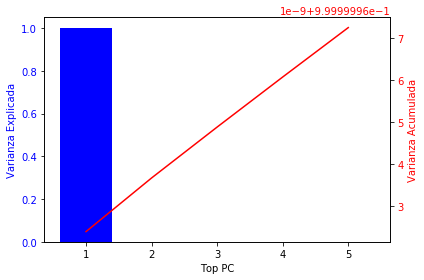

In [23]:
# visualizamos los autovalores

fig, ax1 = plt.subplots()
ax1.set_xlabel('Top PC')
ax1.set_ylabel('Varianza Explicada', color='blue')
ax1.bar(range(1,comp+1), eigenvalues, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Varianza Acumulada', color='red')  # we already handled the x-label with ax1
ax2.plot(range(1,comp+1), eigenvalues_acum, color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

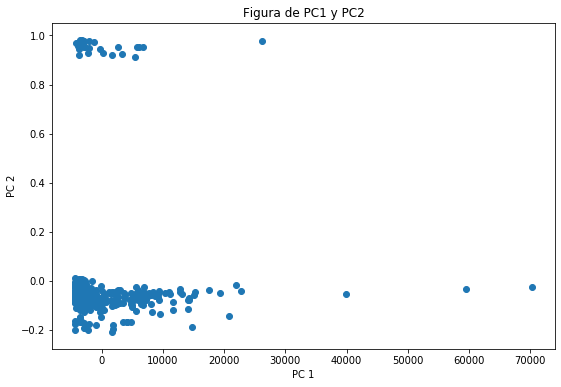

In [24]:
#   gráfico de las muestras en función de las dos componentes principales del PCA.

plt.figure(figsize=(9,6))
plt.scatter(xpca[:,0],xpca[:,1])    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Figura de PC1 y PC2')
plt.show()

In [25]:
#   Generamos nuestro modelo de K-means con 5 clusters y lo ajustamos a nuestros datos.

km = KMeans(n_clusters = 5, n_init = 15, random_state=8000)
km.fit(mod2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=8000, tol=0.0001, verbose=0)

In [26]:
#   Revisamos el valor de silhouette del modelo.

sill_score_km = metrics.silhouette_score(mod2,km.labels_)
print(sill_score_km)

0.6970941572185718


In [27]:
#   Se realiza un Kmeans para los datos luego de aplicado un pca con el fin de poder graficar los centroides de los clusters

reduced_dim = 2
xpca_rd = xpca[:,0:reduced_dim]
kmeans_rd = KMeans(n_clusters=5, random_state=10).fit(xpca_rd)
centers_rd = kmeans_rd.cluster_centers_

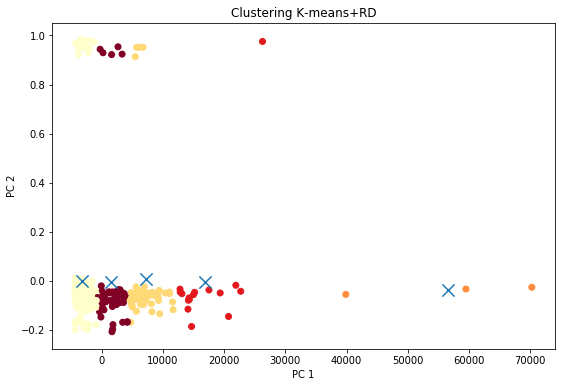

In [28]:
#   Se grafica en un Scatter Plot a que cluster pertenece cada sample y la posición de los centroides de los clusters.


plt.figure(figsize=(9,6))
plt.scatter(xpca_rd[:,0],xpca_rd[:,1],c=kmeans_rd.labels_.astype(float),cmap='YlOrRd')
plt.scatter(centers_rd[:,0], centers_rd[:,1], marker="x", cmap='Set1',s=150)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering K-means+RD')
plt.show()

In [29]:
#   Se unen las labels obtenidas del modelo de K-means al DataFrame original

aux1=pd.DataFrame(km.labels_, columns = ["Cluster"])
mod2og = mod2og.join([aux1])

In [30]:
#   Visualización de la forma del DataFrame con las labels añadidas

mod2og.head(10)

,provincia,cultivo,rendimiento,Cluster
0,BUENOS AIRES,Ajo,3978.088748,4
1,BUENOS AIRES,Alpiste,954.178904,0
2,BUENOS AIRES,Avena,1504.611014,0
3,BUENOS AIRES,Cebada cervecera,2414.116224,0
4,BUENOS AIRES,Cebada forrajera,625.169038,0
5,BUENOS AIRES,Cebada total,4096.151408,4
6,BUENOS AIRES,Cebolla total,9996.105611,2
7,BUENOS AIRES,Centeno,761.004082,0
8,BUENOS AIRES,Colza,1630.526035,0
9,BUENOS AIRES,Cártamo,602.409091,0


In [31]:
#   Función que permite ver que conjunto de Cultivo/Provincia quedo en cada categoria de nivel de rendimiento. Según un orden
#   de mayor a menos rendimiento, los clusters son: 3,1,2,4,0. El código de la función está en el modulo functions que fue
#   importado al inicio.
#   Función functions.clusters (df, yieldlvl = "medio") donde yieldlvl hace referencia al  nivel de rendimiento que se desea
#   consultar. Amite {df = DataFrame mod2og, yieldlvl : ["alto","medioalto","medio","mediobajo", "bajo"]}

fns.clusters(mod2og, "medioalto")

                cultivo   provincia   rendimiento
Cluster                                          
1        Caña de azúcar    SANTA FE  30606.000000
1         Cebolla total    SAN JUAN  27048.153285
1        Caña de azúcar     FORMOSA  26249.777027
1        Caña de azúcar  CORRIENTES  25057.813253
1         Cebolla total     MENDOZA  23689.616246
1        Caña de azúcar       CHACO  21860.048780
1         Cebolla total   RIO NEGRO  19512.362069
1         Cebolla total    LA PAMPA  19333.250000
1                Banana  CORRIENTES  19010.262295
1                Banana       SALTA  18644.072464
1                Banana       JUJUY  18614.392857
1                 Limón     TUCUMAN  18498.535316
1         Cebolla total     CORDOBA  18421.559783
1         Cebolla total    LA RIOJA  17433.927711
1         Cebolla total     NEUQUEN  17162.600000
1                Pomelo   CATAMARCA  17125.000000
